In [17]:
import strategies as s
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
avs = pd.read_csv('./data/avs.csv', encoding='windows-1252')
avs = avs.melt()
x = avs.value
y = avs.variable
y = label_binarize(y, classes=['Wrong', 'Right'])
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [57]:
nbpipe = Pipeline([
    ('countvec', CountVectorizer()),
    ('idf', TfidfTransformer(use_idf=False)),
    ('nb', MultinomialNB())
])
params = {'nb__alpha': np.logspace(-4, 0, 100)}
nb = GridSearchCV(nbpipe, params, n_jobs=-1, cv=10, refit=True)
nb.fit(x_train, y_train);

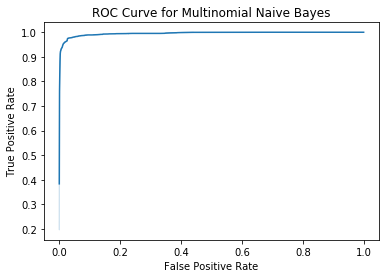

In [76]:
y_pred = nb.predict_proba(x_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
tpr, fpr, thresh = roc_curve(y_test, y_pred)
sns.lineplot(tpr, fpr)
plt.title('ROC Curve for Multinomial Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [78]:
accs = [accuracy_score(y_test, y_pred > th) for th in thresh]
best_i = np.argmax(accs)
print(accs[best_i])
best_th = thresh[best_i]
print(best_th)


0.973851030110935
0.4344199158467637


In [ ]:
model = (nb, best_th)
with open('nbmodel.pkl', 'wb') as f:
    pickle.dump(model, f)

In [2]:
with open('nbmodel.pkl', 'rb') as f:
    nb, thr = pickle.load(f)

In [8]:
dr = s.start_driver()
ops = s.get_options(dr)
nb.predict_proba(o.text for o in ops)[:, 1]


array([[9.99993318e-01, 6.68229000e-06],
       [4.05980447e-04, 9.99594020e-01]])

In [13]:
with open('./records/nb-2-29-2020-1.pkl', 'rb+') as f:
    record = pickle.load(f)
record = np.array(record)
np.sum(record) / len(record)

0.9698025551684089